In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from sktime.utils.plotting import plot_correlations
from statsmodels.api import tsa
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error



plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)

### AR(p)-процесс

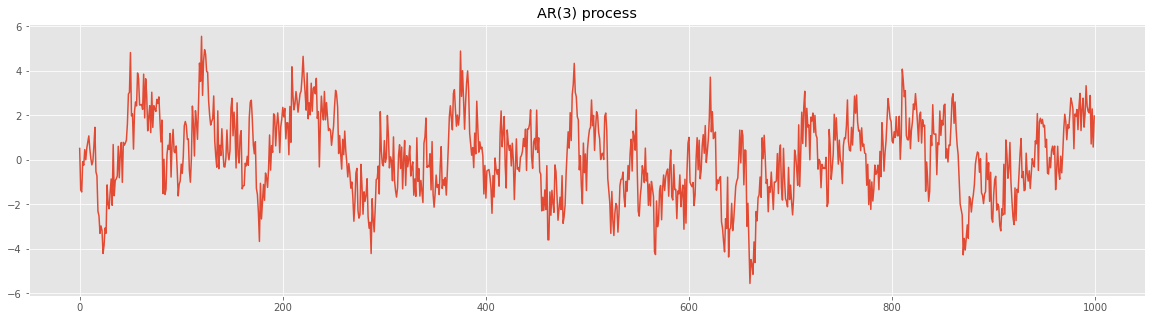

In [14]:
ma_process = tsa.ArmaProcess(ar=[1, -0.5, -0.25, -0.1])
sample = pd.Series(ma_process.generate_sample(nsample=1000, burnin = 10000))
sample.plot()
plt.title('AR(3) process');

In [15]:
sample

0      0.513937
1     -1.351481
2     -1.440301
3     -0.075156
4     -0.236175
         ...   
995    2.894629
996    0.715020
997    2.289296
998    0.576420
999    1.970283
Length: 1000, dtype: float64

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

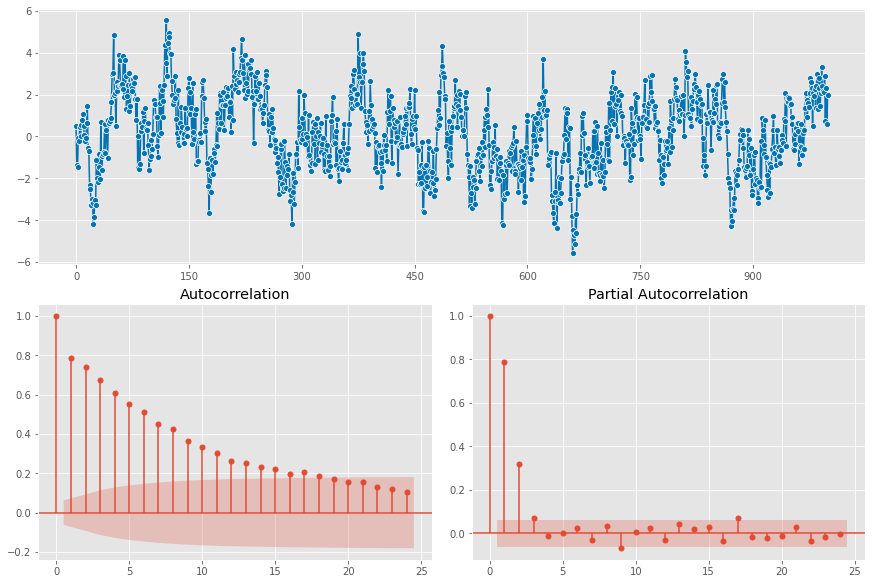

In [16]:
plot_correlations(sample)

In [17]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split

test_size = 50
train, test = temporal_train_test_split(sample, test_size = test_size)

<AxesSubplot:>

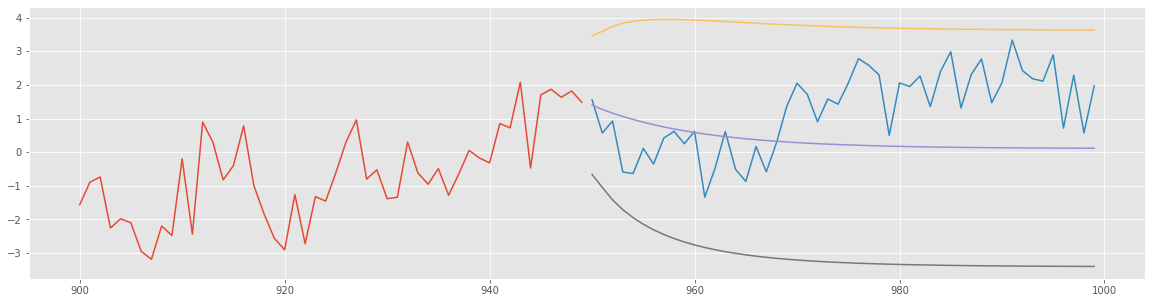

In [18]:
forecaster = ARIMA(order = (3,0,0))

forecaster.fit(train)

forecast = forecaster.predict(list(range(1, test_size+1)))
variance = forecaster.predict_interval(list(range(1, test_size+1)), coverage = 0.05)

train.tail(50).plot()
test.plot()
forecast.plot()
variance['Coverage'][0.05]['lower'].plot()
variance['Coverage'][0.05]['upper'].plot()

In [23]:
forecaster.predict(list(range(1, 1000+1)))

950     1.397433
951     1.271767
952     1.160630
953     1.062385
954     0.972230
          ...   
1945    0.105959
1946    0.105959
1947    0.105959
1948    0.105959
1949    0.105959
Length: 1000, dtype: float64

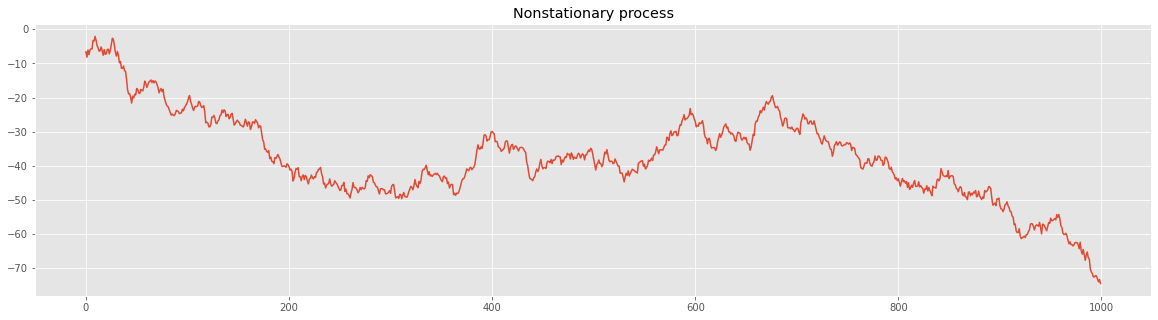

In [24]:
nonstationary_process = tsa.ArmaProcess(ar=[1, -1])
sample = pd.Series(nonstationary_process.generate_sample(nsample=1000, burnin = 10000))
sample.plot()
plt.title('Nonstationary process');


In [26]:
nonstationary_process.isstationary

False

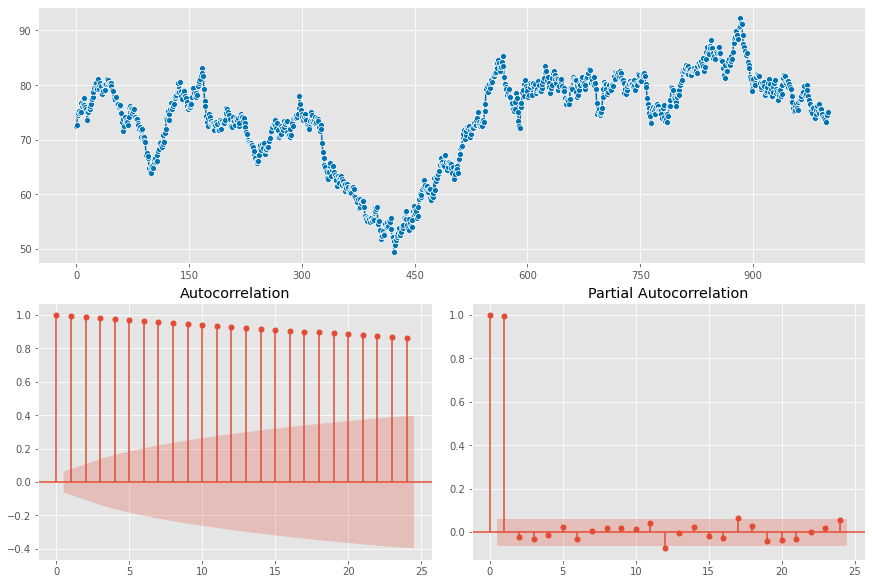

In [35]:
plot_correlations(sample);

### ARMA(p,q)-процесс

Теперь попробуем взять реальные данные и оценить характеристики некоторого ARMA(p,q)-процесса. Возьмём какой-нибудь стационарный ряд.

In [29]:
import statsmodels.api as sm
data = sm.datasets.macrodata.load_pandas().data

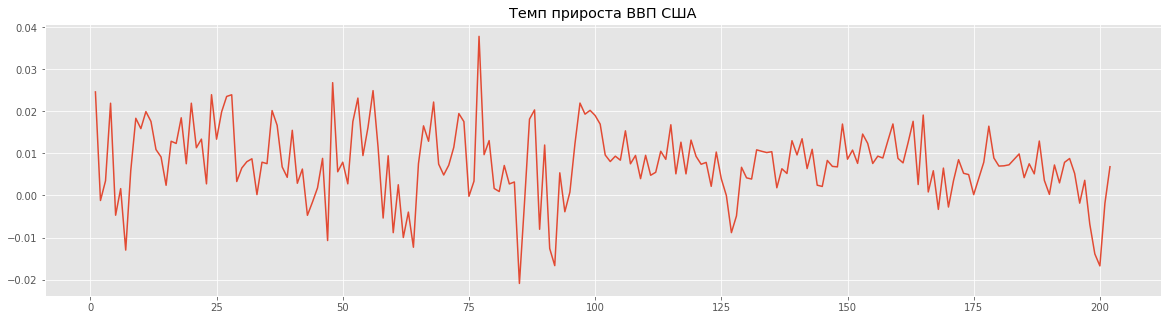

In [30]:
g_rate = (data.realgdp.diff() / data.realgdp).dropna()
g_rate.plot()
plt.title("Темп прироста ВВП США");

Посмотрим на коррелограммы

In [31]:
test_size = 20
train, test = temporal_train_test_split(g_rate, test_size = test_size)

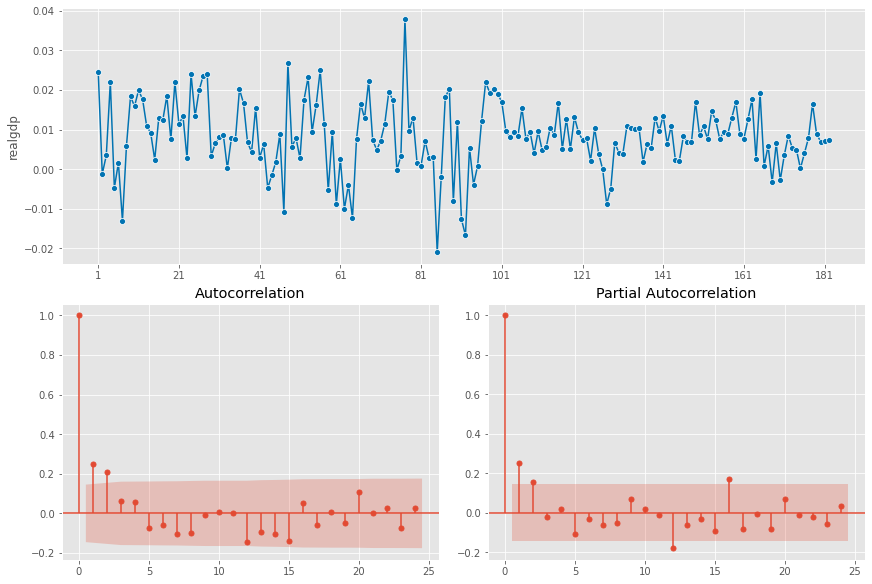

In [32]:
plot_correlations(train);

/home/the_sun/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/the_sun/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/the_sun/.local/lib/python3.8/site-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


Forecast error: 0.8592272814588643


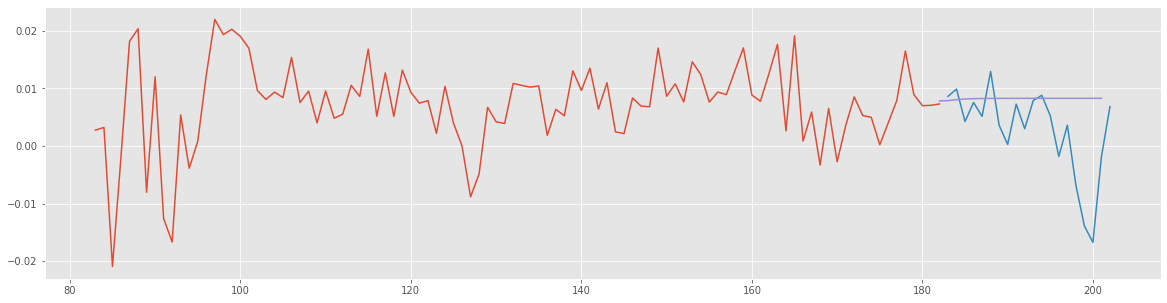

In [33]:
from sktime.forecasting.arima import AutoARIMA, ARIMA

fh = list(range(len(test)))
forecaster = AutoARIMA(max_p=2, max_q=2,stationary=True)
forecaster.fit(train)
prediction = forecaster.predict(fh=fh)

train.tail(100).plot()
test.plot()
prediction.plot()
print(f'Forecast error: {mean_absolute_percentage_error(test, prediction)}')

/home/the_sun/.local/lib/python3.8/site-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

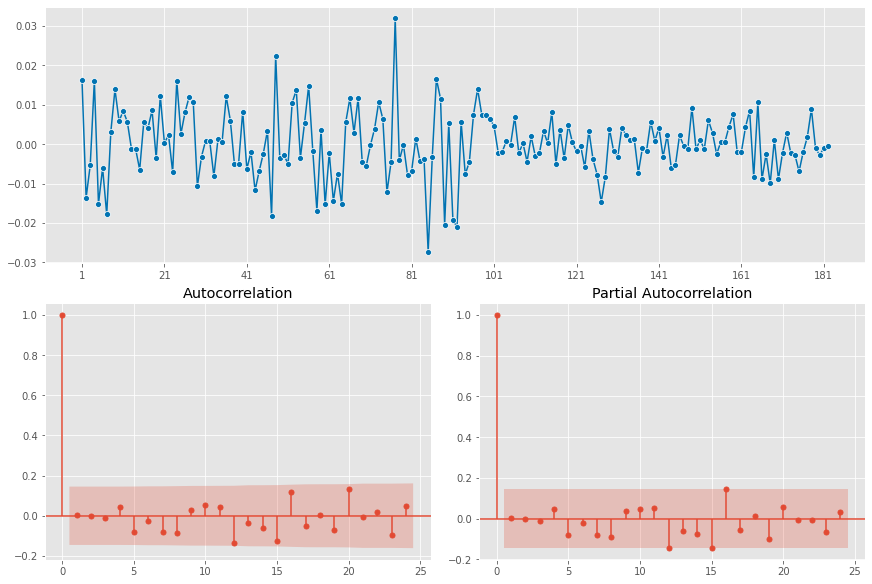

In [35]:
plot_correlations(forecaster.predict_residuals())

In [65]:
forecaster.get_fitted_params()

{'intercept': 0.005711217533351699,
 'ar.L1': 0.21407579043700997,
 'ar.L2': 0.17592959224314694,
 'ar.S.L12': -0.13257568005557446,
 'sigma2': 6.744582765375445e-05,
 'order': (2, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -1220.9772224120316,
 'aicc': -1220.6363133211225,
 'bic': -1204.9571889766476,
 'hqic': -1214.4829339556586}

In [36]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  182
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 614.020
Date:                Mon, 28 Feb 2022   AIC                          -1220.040
Time:                        10:18:41   BIC                          -1207.224
Sample:                             0   HQIC                         -1214.844
                                - 182                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0052      0.001      6.547      0.000       0.004       0.007
ar.L1          0.2123      0.069      3.079      0.002       0.077       0.347
ar.L2          0.1560      0.065      2.410      0.016       0.029       0.283
sigma2      6.862e-05   5.59e-06     12.285      0.000    5.77e-05    7.96e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.86
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/the_sun/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast error: 0.8601168330980234


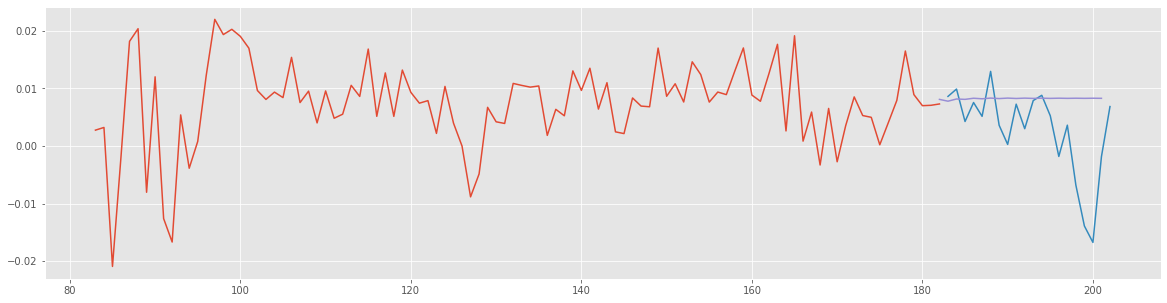

In [37]:
fh = list(range(len(test)))
forecaster = ARIMA(order=(2,0,2))
forecaster.fit(train)
prediction = forecaster.predict(fh=fh)

train.tail(100).plot()
test.plot()
prediction.plot()
print(f'Forecast error: {mean_absolute_percentage_error(test, prediction)}')